In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl
from scipy.signal import savgol_filter
from functools import cached_property
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cosine
import pickle
import os

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Steps for linearisation


#### Get maze coordinates exact

#### DONE  ------       Smoothen interpolate the whl files  

#### mark the arms and rings for linearisation 

- start with reward zone to be in both arm and outer ring

- add condition to select outer ringwhen it moves

- add condition for start zone

- add another radius for outer ring and when in arms that is when in arm the outer radius is a bit bigger and when in outer ring the radius is smaller

#### segement the events

- see coordinates of whl and which arm it corresponds to in the linear track

- simply allot it that arm and the position on that arm

- mark for outer rings

- add condition for start zone back and forth

- also need to segment the spike id and the spike times lmao. data structure per trial like chai drew not bad



---- add condition for vlad too



In [4]:
def smoothen_positions(position, window_size = 30, poly_degree = 1, bin_len = 25.6, speed_thr = 10, speed_violation = 90):
    """ Smoothen positions and correct for abnormally high speed due to head jerks
    
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,2)
            window_size = number of bins for savitkzky golay filter
            poly_degree = order of savitzky filter to use
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
            speed_violation - speed in cm/s that is max achievable by rat. anything above it is due to head jerk
        Return:
            positions smoothened and corrected for jumps/head jerks based on speed
    """
    
    assert speed_thr is not None

    smooth_pos = position.copy()
    smooth_pos[:,0] = savgol_filter(position[:,0], window_size, poly_degree)
    smooth_pos[:,1] = savgol_filter(position[:,1], window_size, poly_degree)
    
    speed = np.array( jcl.utils.calc_speed(smooth_pos,bin_len) )
    speed_violation_index = np.where(speed > speed_violation)[0]
    
#     print(speed_violation_index, speed_violation)
                                                              
    for i in speed_violation_index:
        smooth_pos[i,0] = np.mean( smooth_pos[i-5:i, 0] ) ##can also use the next 5 to get some smooth. do if needed
        smooth_pos[i,1 ]= np.mean( smooth_pos[i-5:i, 1] )

    return smooth_pos

def interpolate_positions(pos, unknown_val=1023, interp_order=1):
    """ Interpolate position to remove unknown position value
    
        pos = position dataframe with columns x1 and y1 that have the positions
        Return:
        
        (n,2) array of interpolated positions
    """                                                          
                                                              
                                                              
    pos["x1"],pos["y1"] = jcl.utils.interpolate_position(pos["x1"], pos["y1"], unknown_val, interp_order)
    position = np.column_stack(( pos["x1"], pos["y1"] ))
    return position

In [6]:
    
days = ['09','10','20']
exp = "JC283-202209"
time_bin = 25.6 # in ms   20ms is 512 pts    20000/39.0625

for day in days:
    
    path = "./m" + exp + day + "/"
    des_path = path + exp + day + '.des'
    results_dir = './m' + exp + day + "/rate_maps/"
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    
    with open(des_path, 'r') as file:
        des = np.array(file.read().split())
    
    binned_data = np.array([None, None])
    speed_filtered_positions = np.array([None, None])
    smooth_pos = np.array([None, None])
    
    for training_num in [1,2]:

        clu_path = path + exp + day + '_training' + str(training_num) + '.clu'
        res_path = path + exp + day + '_training' + str(training_num) + '.res'
        whl_path = path + exp + day + '_training' + str(training_num) + '.whl'
                                                        
        pos =  pd.read_csv(  whl_path,
                            sep=" ",
                            header=None,
                            names=["x1","y1"]   )
                                                              
        positions = 1.24 * interpolate_positions(pos, unknown_val=1023, interp_order=1) ## 1 pix is 1.24 cm
        smooth_pos[training_num - 1] =  pd.DataFrame(  smoothen_positions(positions, 100, 1,  speed_violation = 80), columns =['x1','y1']   )
    print(smooth_pos)

[                x1          y1
 0       154.999018  143.407105
 1       155.003296  143.333434
 2       155.007575  143.259763
 3       155.011853  143.186093
 4       155.016132  143.112422
 ...            ...         ...
 112056  167.205618  132.852618
 112057  167.182269  132.882574
 112058  167.158920  132.912531
 112059  167.135571  132.942487
 112060  167.112222  132.972444

 [112061 rows x 2 columns]                      x1          y1
                                0       150.573323  135.415735
                                1       150.756690  135.362847
                                2       150.940057  135.309960
                                3       151.123424  135.257072
                                4       151.306792  135.204184
                                ...            ...         ...
                                203346  167.347528  133.920000
                                203347  167.344194  133.920000
                                203348  167.3408

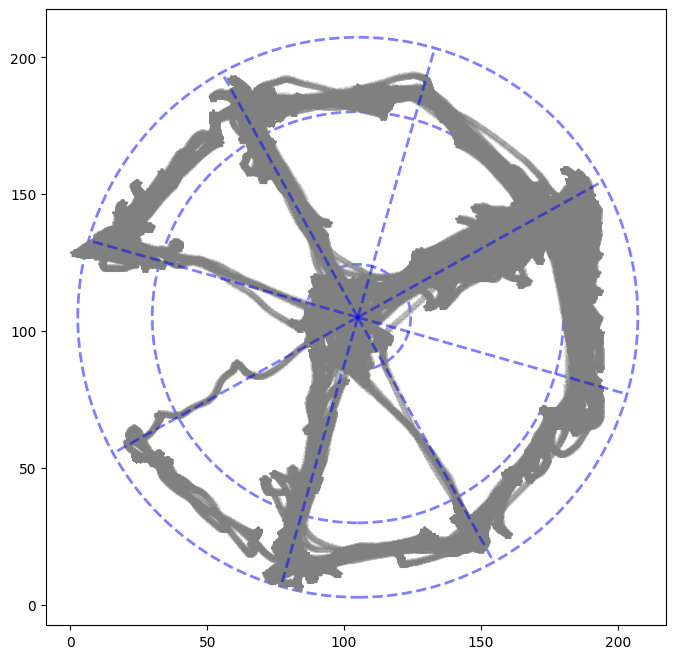

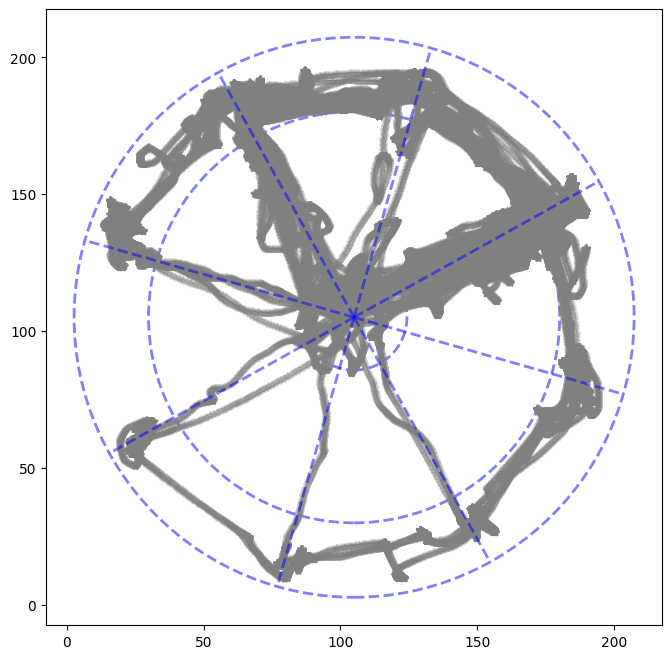

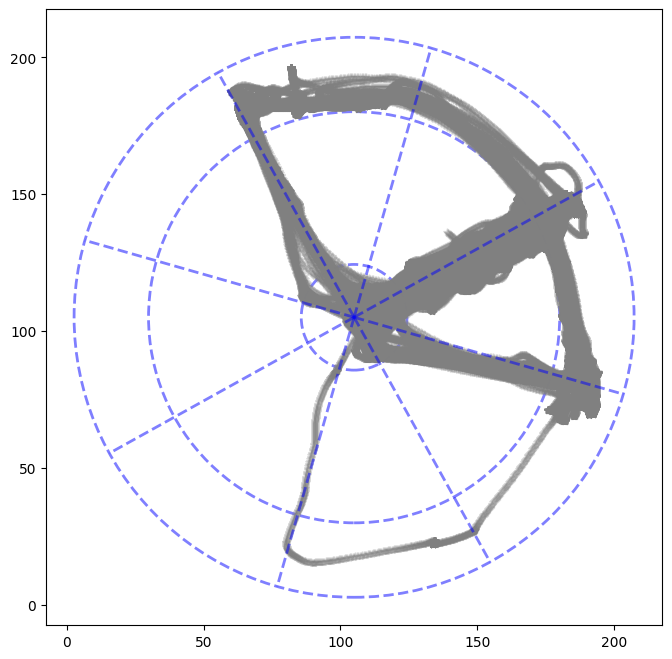

In [18]:
def adjust_maze_params(trajectory_df, center_coords, arm_length, arm_width, arm1_coords, maze_type):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    maze_params = get_maze_params(center_coords, arm_length, arm_width, arm1_coords, maze_type)

    ax.plot(trajectory_df[trajectory_df.x1 != 1023].x1, trajectory_df[trajectory_df.y1 != 1023].y1,'*',
                            color='gray', alpha=0.2, linewidth=0.5)

    mask_good=plot_maze_scheme(ax, maze_params, maze_type, color='blue')
    ax.set_aspect('equal')
    plt.show()
#     plt.imshow(mask_good, cmap='hot', interpolation='nearest')
#     plt.show()
    return mask_good

def get_maze_params(center_coords, arm_length, arm_width, arm1_coords, maze_type):
    maze_params = {}
    maze_params['center_coords'] = np.array(center_coords)
    maze_params['arm_length'] = arm_length
    maze_params['arm_width'] = arm_width
    # compute radius of the inner circle of the octagon of the center arena
    maze_params['inner_radius'] = 0.5 * maze_params['arm_width'] * (1 + np.sqrt(2))
    # total distance from the end of the arm to the maze center
    maze_params['maze_radius'] = maze_params['inner_radius'] + maze_params['arm_length']
    # coordinates of an arbitrary point that belongs to the center of the first arm
    maze_params['arm1_coords'] = np.array(arm1_coords)
    maze_params['arm1_angle'] = np.arctan2(maze_params['arm1_coords'][1] - maze_params['center_coords'][1], maze_params['arm1_coords'][0] - maze_params['center_coords'][0])
    maze_params['arms_coords'] = {}
    for i in range(0, 8):
        rotation_angle = i * np.pi / 4

        sin = np.sin(maze_params['arm1_angle'] - rotation_angle)
        cos = np.cos(maze_params['arm1_angle'] - rotation_angle)

        maze_params['arms_coords'][i] = np.array([maze_params['center_coords'][0] + maze_params['maze_radius'] * cos,
                                                  maze_params['center_coords'][1] + maze_params['maze_radius'] * sin])

    distance = np.array([np.linalg.norm( maze_params['arms_coords'][i] -maze_params['arm1_coords'])    for i in range(0, 8)])
    maze_params['opposite_index'] = np.argmax(distance)
    maze_params['start_index']    = np.argmin(distance)

    if maze_type == 'andrea':
        maze_params['outer_radius'] = maze_params['inner_radius'] + maze_params['arm_length'] - 1.7*maze_params['arm_width'] 
        
    return maze_params

def plot_maze_scheme(ax, maze_params, maze_type, color='black'):
    for i in range(0, 8):
        rotation_angle = i * np.pi / 4

        sin = np.sin(maze_params['arm1_angle'] - rotation_angle)
        cos = np.cos(maze_params['arm1_angle'] - rotation_angle)

        # center of the corresponding arm
        ax.plot([maze_params['center_coords'][0], maze_params['center_coords'][0] + maze_params['maze_radius'] * cos],
                [maze_params['center_coords'][1], maze_params['center_coords'][1] + maze_params['maze_radius'] * sin],
                linestyle='dashed', alpha=0.5, color=color, linewidth=2
                )
        
    circle = plt.Circle(maze_params['center_coords'], maze_params['maze_radius'], color=color, linestyle='dashed',
                        alpha=0.5,
                        fill=False,
                        linewidth=2)
    ax.add_patch(circle)
    
    circle = plt.Circle(maze_params['center_coords'], maze_params['inner_radius'], color=color, linestyle='dashed',
                        alpha=0.5,
                        fill=False,
                        linewidth=2)
    ax.add_patch(circle)
    
    if maze_type == 'andrea':
        circle = plt.Circle(maze_params['center_coords'], maze_params['outer_radius'], color=color, linestyle='dashed',
                            alpha=0.5,
                            fill=False,
                            linewidth=2)
        ax.add_patch(circle)
    
    return

center_coords=[105,105]
arm_length = 83
arm_width = 16
arm1_coords = [150,130]

speed_threshold=5
window_length=25.6
sample_rate_whl=39.0625
sample_rate_data=20000

days = ['09','10','20']
exp = "JC283-202209"
time_bin = 25.6 # in ms   20ms is 512 pts    20000/39.0625

for day in days:
    
    path = "./m" + exp + day + "/"
    des_path = path + exp + day + '.des'
    results_dir = './m' + exp + day + "/rate_maps/"
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    
    with open(des_path, 'r') as file:
        des = np.array(file.read().split())
    
    binned_data = np.array([None, None])
    speed_filtered_positions = np.array([None, None])
    smooth_pos = np.array([None, None])
    
    for training_num in [1,2]:

        clu_path = path + exp + day + '_training' + str(training_num) + '.clu'
        res_path = path + exp + day + '_training' + str(training_num) + '.res'
        whl_path = path + exp + day + '_training' + str(training_num) + '.whl'
                                                        
        pos =  pd.read_csv(  whl_path,
                            sep=" ",
                            header=None,
                            names=["x1","y1"]   )
                                                              
        positions = 1.24 * interpolate_positions(pos, unknown_val=1023, interp_order=1) ## 1 pix is 1.24 cm
        smooth_pos[training_num - 1] =  pd.DataFrame(  smoothen_positions(positions, 100, 1,  speed_violation = 80), columns =['x1','y1']   )
     
    mask_good = adjust_maze_params(
                                    pd.concat([smooth_pos[0], smooth_pos[1]], ignore_index=True, axis=0),
                                    center_coords = center_coords,
                                    arm_length = arm_length,
                                    arm_width = arm_width,
                                    arm1_coords = arm1_coords,
                                    maze_type = "andrea" ) #or "vlad"

In [19]:
def perpendicular_distance(point_x, point_start, point_end):
    # Coefficients of the line Ax + By + C = 0
    A = point_start[1] - point_end[1]
    B = point_end[0] - point_start[0]
    C = point_start[0] * point_end[1] - point_end[0] * point_start[1]
    # Perpendicular distance formula
    distance = np.abs(A * point_x[0] + B * point_x[1] + C) / np.linalg.norm([A, B])
    return distance

def is_point_above_line(points, line_start, line_end):
    # Vector from line_start to line_end
    line_vector = line_end - line_start
    # Vector from line_start to each data point
    point_vectors = points - line_start
    # Calculate cross product (z-component) between line_vector and point_vectors
    cross_product = np.cross(line_vector, point_vectors)
    return cross_product > 0

def get_linearized_pos(point, maze_params):
    """
    :param point: point coordinates (x, y)
    :param maze_params: dictionary of maze description parameters
    :return: (arm_ID, pos):
            * (-1, dist), where dist is distance to the center of the maze, in case the rat is at the central arena
            * (armID, linearized position in the arm), otherwise
    """
    dist_to_center = np.linalg.norm(point - maze_params['center_coords'])
    angles = []
    if dist_to_center == 0:
        return pd.Series([0, 0], index=['arm_ID', 'linearized_pos'])
    else:
        for _, arm_endpoint in maze_params['arms_coords'].items():
            np.seterr('raise')
#             print(point - maze_params["center_coords"])
#             print(f'nominator: {np.dot(point - maze_params["center_coords"], arm_endpoint - maze_params["center_coords"])}')
#             print(f'denominator: {np.linalg.norm(point - maze_params["center_coords"]) * np.linalg.norm(arm_endpoint - maze_params["center_coords"])}')
            cos = np.dot(point - maze_params['center_coords'], arm_endpoint - maze_params['center_coords']) / (
                    np.linalg.norm(point - maze_params['center_coords']) *  np.linalg.norm( arm_endpoint - maze_params['center_coords']) )
            # due to float point calculations, we can obtain values >|1|
            if cos > 1:
                cos = 1
            if cos < -1:
                cos = -1
            angles.append(np.arccos(cos))
            
        arm_ID = np.argmin(angles)
        # length of projection on the closest arm, starting from the beginning of the arm
        linearized_pos = dist_to_center * np.cos(np.min(angles)) 
        
        if linearized_pos >= maze_params['inner_radius']:

            # we start indexing arms from 1
            if np.linalg.norm(point - maze_params['center_coords']) >= maze_params['outer_radius']: # is rat in outer ring

                distance = perpendicular_distance(point, maze_params['center_coords'], maze_params['arms_coords'][arm_ID]  ) # perp distance from the line octagon
                
                if distance > maze_params['arm_width']/1.5 : ## if not divide by 2 then do 1.5
                    ## if the distance is further away from the reward arm of any arm
                    ## which outer maze is the rat in
                    if is_point_above_line(point, maze_params['arms_coords'][maze_params['start_index']], maze_params['arms_coords'][maze_params['opposite_index']]):
                        angle = maze_params['arm1_angle'] - np.arctan2(point[1] - maze_params['center_coords'][1],
                                           point[0] - maze_params['center_coords'][0])  ### if negative you get +ve angle wrt start and if positive you get angle to start
                        linearized_pos =  4 * 70 * angle/np.pi     ## theta * r / (4/4 * pi * r) ### assumes location of 3 and 4 block part of the maze
                        return pd.Series([9 , linearized_pos], index=['arm_ID', 'linearized_pos'])
                    else:
                        angle = np.arctan2(point[1] - maze_params['center_coords'][1],
                                           point[0] - maze_params['center_coords'][0]) - maze_params['arm1_angle'] ## to get angle wrt start 
                        linearized_pos = 4 * 70 * angle/np.pi    ## theta * r / (3/4 * pi * r) ###2 pi/8 = 70    so x is what ?
                        
                        return pd.Series([10 , linearized_pos], index=['arm_ID', 'linearized_pos'])
       
                else: ## if it is in the reward zone of the arms
            
                    if arm_ID == maze_params['start_index']: ## want separate reward zone for the start arm
                        return pd.Series([11, linearized_pos], index=['arm_ID', 'linearized_pos'])
                    else: ##for everything else we dont care about separating reward zone
                        return pd.Series([(arm_ID + 1),linearized_pos], index=['arm_ID', 'linearized_pos'])
                
            else:
                return pd.Series([(arm_ID+1), linearized_pos], index=['arm_ID', 'linearized_pos'])
            
        else:
            # since the central area is octagonal, not circular
            return pd.Series([0, dist_to_center], index=['arm_ID', 'linearized_pos'])  # the point is in the central area
        
def eight_arm_maze_linearization(trajectory_df, maze_params):
    """
    path_to_trajectory_file: path to smoothed trajectory .csv file
    :return:
    """    
    
    trajectory_df[['arm_ID', 'linearized_pos']] = trajectory_df.apply( lambda x: get_linearized_pos( np.array([x.x1, x.y1]), maze_params ) , axis = 1 )
    # if linearized pos > arm length:
    # 1) linearised pos = arm length
    # 2) ? exit the program and ask to redo maze params file with better center coord
#     trajectory_df.linearized_pos[trajectory_df.linearized_pos > maze_params['arm_length']] = maze_params['arm_length'] - 0.25
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(trajectory_df.x1, trajectory_df.y1, c=trajectory_df.arm_ID.values, s=1,
                         cmap='tab20')
    plot_maze_scheme(ax, maze_params, 'andrea', color='silver')
    
    ax.set_aspect('equal')
    # produce a legend with the unique colors from the scatter
    handles, labels = scatter.legend_elements()
    # replacing '-1' with 'maze center' label
    labels[0] = 'position unknown'
    ax.legend(handles, labels,
                        title="Arm ID",
                        bbox_to_anchor=(1, 1),
                        frameon=False
                        )
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close(fig)        
    return trajectory_df

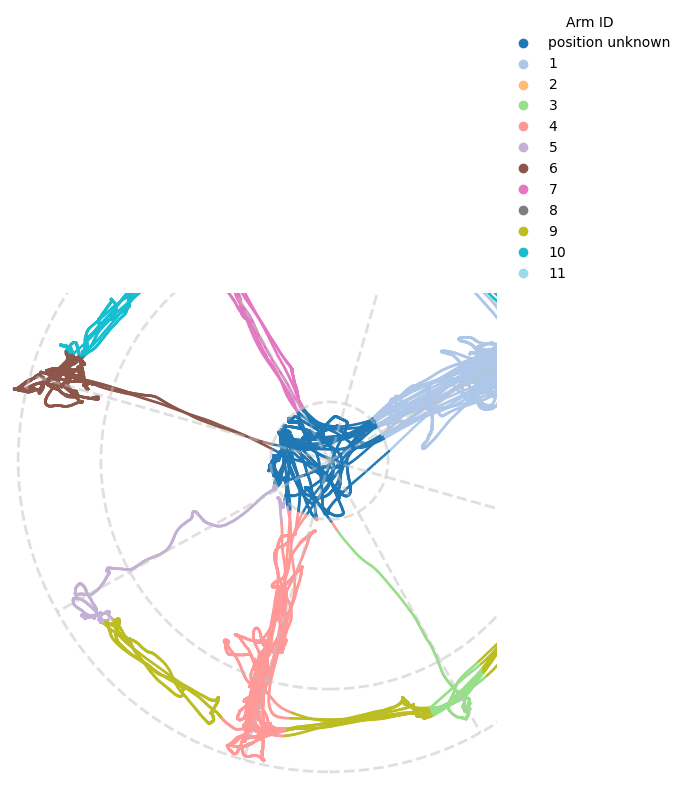

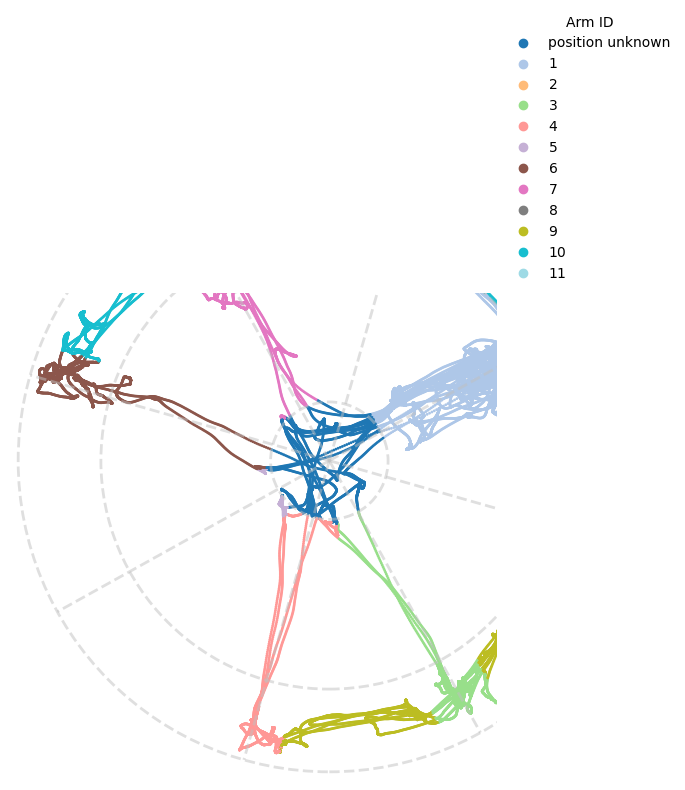

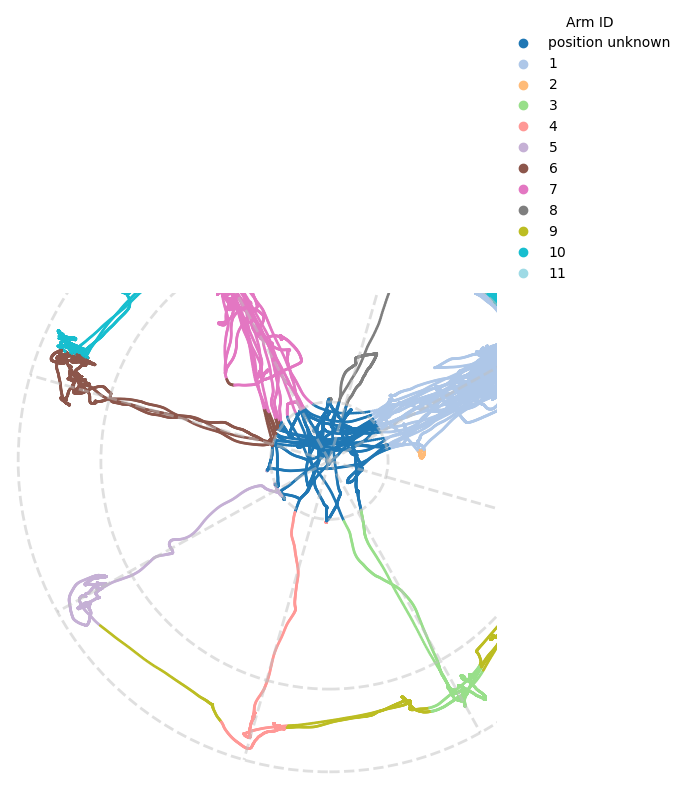

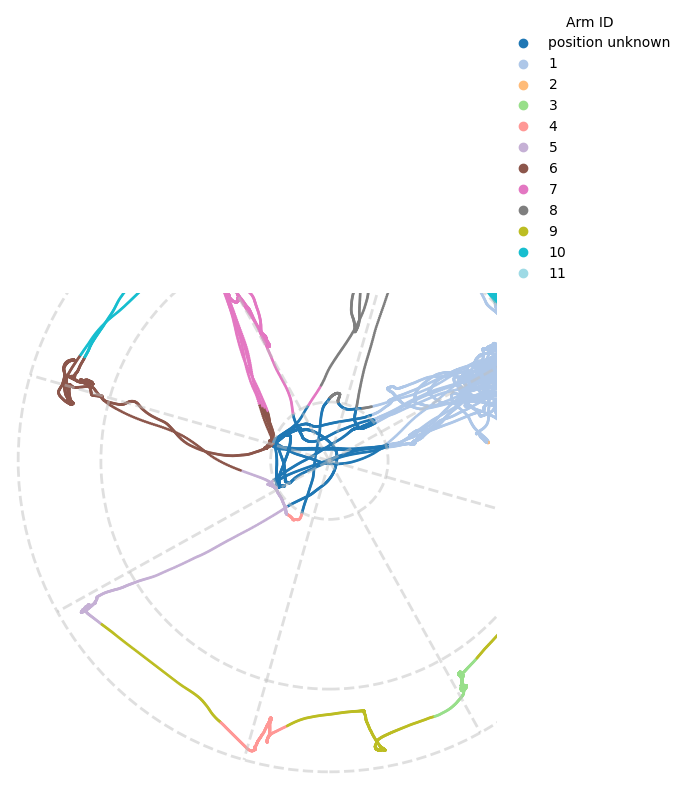

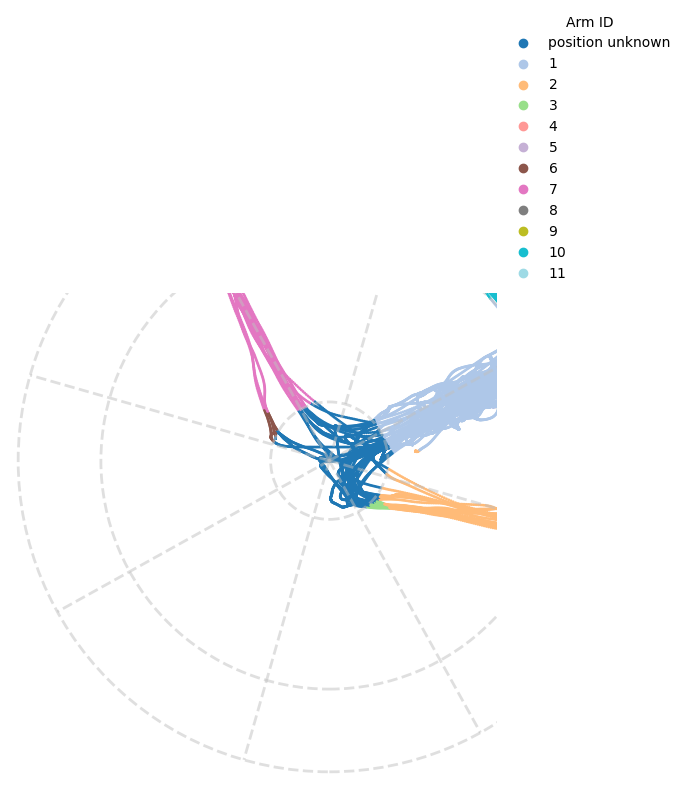

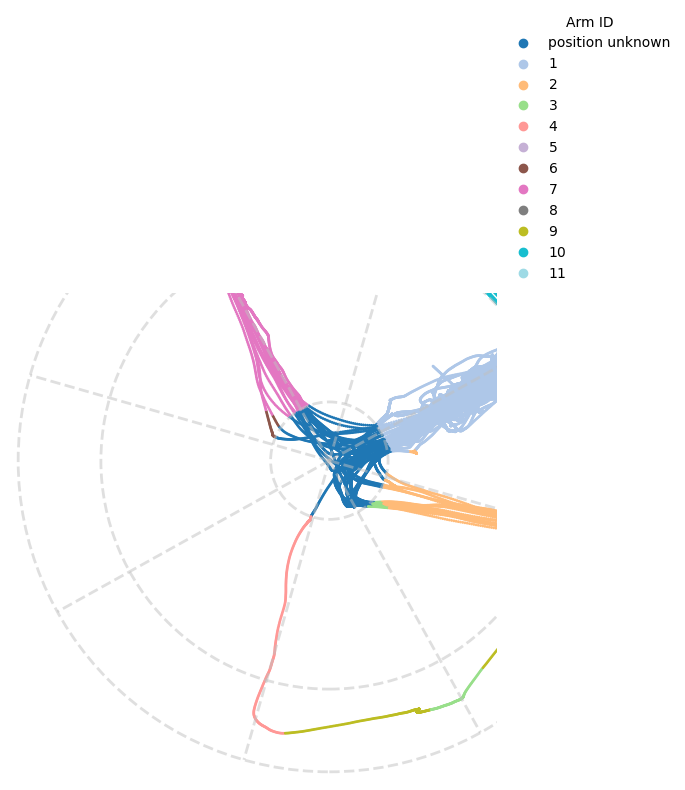

In [26]:
days = ['09','10','20']
exp = "JC283-202209"
time_bin = 25.6 # in ms   20ms is 512 pts    20000/39.0625

for day in days:
    
    path = "./m" + exp + day + "/"
    des_path = path + exp + day + '.des'
    results_dir = './m' + exp + day + "/rate_maps/"
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    
    with open(des_path, 'r') as file:
        des = np.array(file.read().split())
    
    for training_num in [1,2]:

        clu_path = path + exp + day + '_training' + str(training_num) + '.clu'
        res_path = path + exp + day + '_training' + str(training_num) + '.res'
        whl_path = path + exp + day + '_training' + str(training_num) + '.whl'
                                                        
        pos =  pd.read_csv(  whl_path,
                            sep=" ",
                            header=None,
                            names=["x1","y1"]   )
                                                              
        positions = 1.24 * interpolate_positions(pos, unknown_val=1023, interp_order=1) ## 1 pix is 1.24 cm
        smooth_pos =  eight_arm_maze_linearization(pd.DataFrame( smoothen_positions(positions, 100, 1,  speed_violation = 80), columns =['x1','y1']   ), maze_params)
        
        smooth_pos.to_csv(path + exp + day + '_training' + str(training_num) + '.lwhl', index=False, sep = ',')

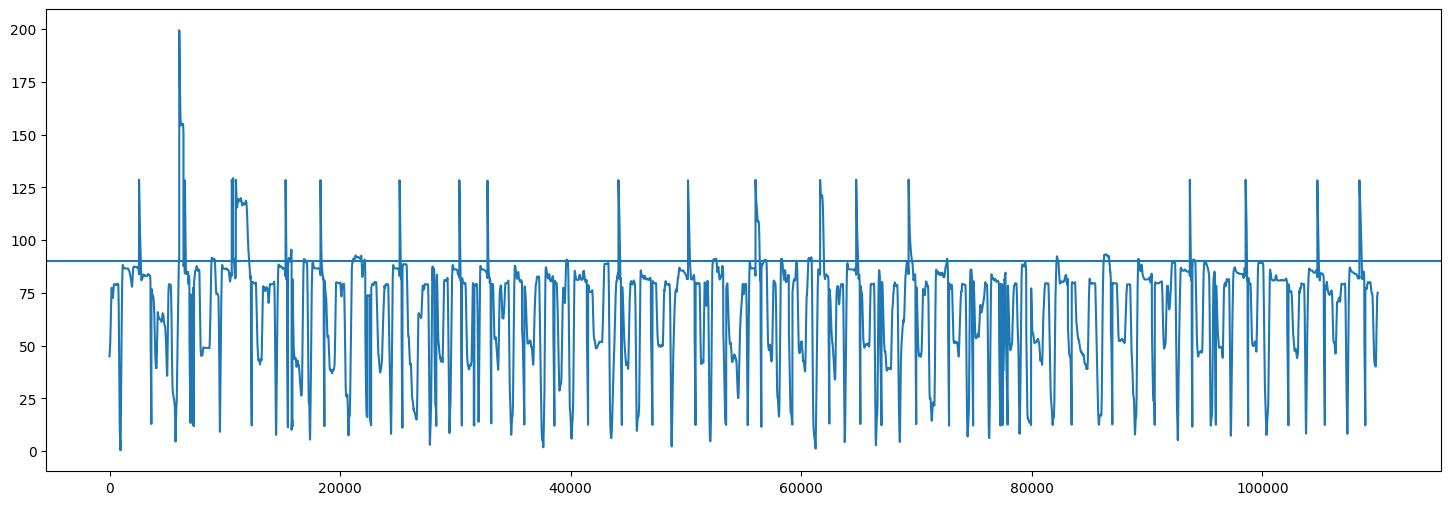

In [25]:
plt.figure(figsize=(18,6))
plt.plot(smooth_pos.linearized_pos)
plt.axhline(y=90)
# plt.plot(pos.x1)
# plt.plot(pos.y1)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
scatter = ax.scatter(pos.x1, pos.y1, c=pos.arm_ID.values, s=1,
                     cmap='tab20')
plot_maze_scheme(ax, maze_params, 'andrea', color='silver')

ax.set_aspect('equal')
# produce a legend with the unique colors from the scatter
handles, labels = scatter.legend_elements()

ax.legend(handles, labels,
                    title="Arm ID",
                    bbox_to_anchor=(1, 1),
                    frameon=False
                    )
plt.xlim([0,180])
plt.ylim([0,180])

ax.axis('off')
plt.tight_layout()
plt.show()
plt.close(fig)    